The notebook is a continuation of the first model trained. In this notebook we are going to train two other text classification models and host them on hugging face.

## Mounting the drive with datasets

In [1]:
!pip3 install -qU transformers[all] datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadat

In [2]:
#Disable  W&B
import os
os.environ['WANDB_DISABLED'] = 'true'

In [3]:
#Account Authentication
from google.colab import auth
auth.authenticate_user()

In [4]:
# Mounting the datasets/requirements text file from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## I. INSTALLATION OF REQUIRED LIBRARIES

In [5]:
#importations
!pip install datasets
!pip install transformers
!pip install transformers[torch] --upgrade
!pip install accelerate -u
!pip3 install huggingface_hub


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


In [6]:
#Creating a hugging face login to save our models
from huggingface_hub import notebook_login
notebook_login()

In [32]:
#Data Exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Modelling
from datasets import load_dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import DataCollatorWithPadding
import warnings
import torch
warnings.filterwarnings("ignore")

## II. LOADING DATASETS FROM THE DRIVE

In [10]:
# Navigating to the directory where the datasets are stored
%cd /content/drive/My Drive/Azubi-Africa--P5-Natural-Language-Processing-Project-Sentiment-Analysis/data

# Load the train and test data
train = pd.read_csv('Train.csv')
# A way to eliminate rows containing NaN values
train = train[~train.isna().any(axis=1)]
test = pd.read_csv('Test.csv')
# A way to eliminate rows containing NaN values
test = test[~test.isna().any(axis=1)]

/content/drive/My Drive/Azubi-Africa--P5-Natural-Language-Processing-Project-Sentiment-Analysis/data


## EDA ANALYSIS
Here are going to explore the datasets to gain insights

In [11]:
#data previewing
train.head(5)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [49]:
#rechecking the columns
train.columns

Index(['tweet_id', 'safe_text', 'label', 'agreement'], dtype='object')

In [50]:
#checking shape
train.shape, test.shape

((9999, 4), (5176, 2))

In [51]:
#data previewing
test.head(5)

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [52]:
#preview test data
test.columns

Index(['tweet_id', 'safe_text'], dtype='object')

In [53]:
#checking statistical distribution
train.describe()

,label,agreement
count,9999.00000,9999.000000
mean,0.30153,0.854252
std,0.64674,0.180707
min,-1.00000,0.333333
25%,0.00000,0.666667
50%,0.00000,1.000000
75%,1.00000,1.000000
max,1.00000,1.000000


In [54]:
#checking info
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 10000
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   9999 non-null   object 
 1   safe_text  9999 non-null   object 
 2   label      9999 non-null   float64
 3   agreement  9999 non-null   float64
dtypes: float64(2), object(2)
memory usage: 390.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5176 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   5176 non-null   object
 1   safe_text  5176 non-null   object
dtypes: object(2)
memory usage: 121.3+ KB


(None, None)

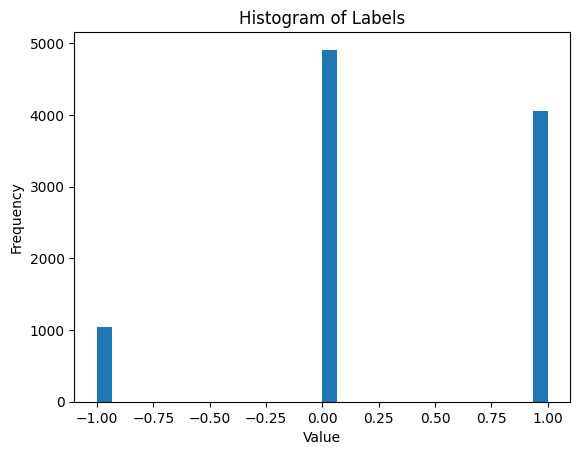

In [55]:
#Exploring distribution of the dataset
# Selecting numerical and categorical columns
numerical_columns = train.select_dtypes(exclude=['object'])

# Histogram of a numerical column
plt.hist(numerical_columns['label'], bins=30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Labels')
plt.show()

The labels 0 have higher frequency as shown in the histogram. Most of the tweets response is neutral responses.

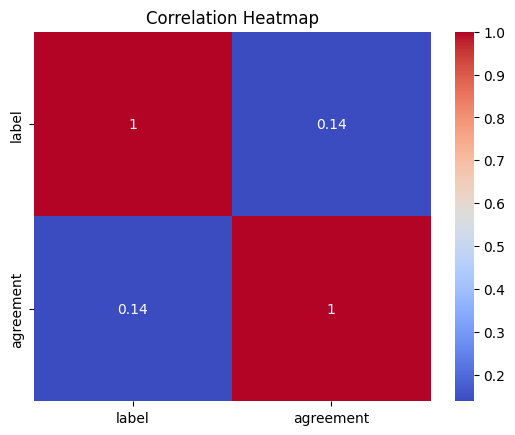

In [56]:
#checking correlation analysis
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

There is a positive relationship between labels and agreements of 0.14 which indicates there is no linear relationship between the variables

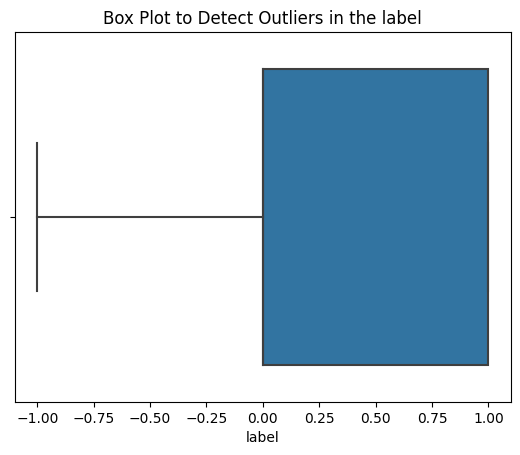

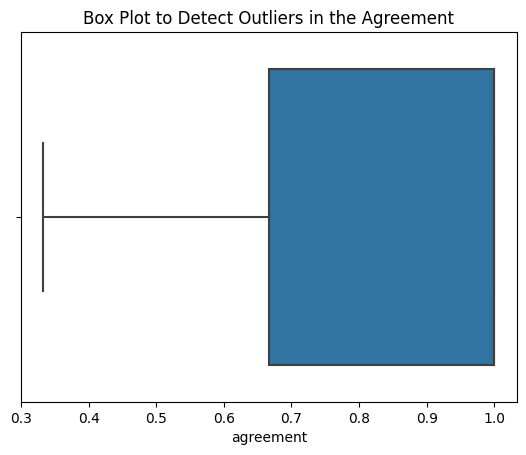

In [57]:
#checking for outliers in the agreement and labels
sns.boxplot(data=train, x='label')
plt.title('Box Plot to Detect Outliers in the label')
plt.show()

sns.boxplot(data=train, x='agreement')
plt.title('Box Plot to Detect Outliers in the Agreement')
plt.show()

From the box plots there are not outliers in the datasets

In [58]:
#checking for null values
train.isnull().sum(), test.isnull().sum()

(tweet_id     0
 safe_text    0
 label        0
 agreement    0
 dtype: int64,
 tweet_id     0
 safe_text    0
 dtype: int64)

There are no missing values in the train and test datasets.

In [60]:
# Assuming 'labels' are the target column in your dataset
unique_classes = train['label'].unique()
num_classes = len(unique_classes)
print("Number of unique classes:", num_classes)
print("Unique classes:", unique_classes)

Number of unique classes: 3
Unique classes: [ 0.  1. -1.]


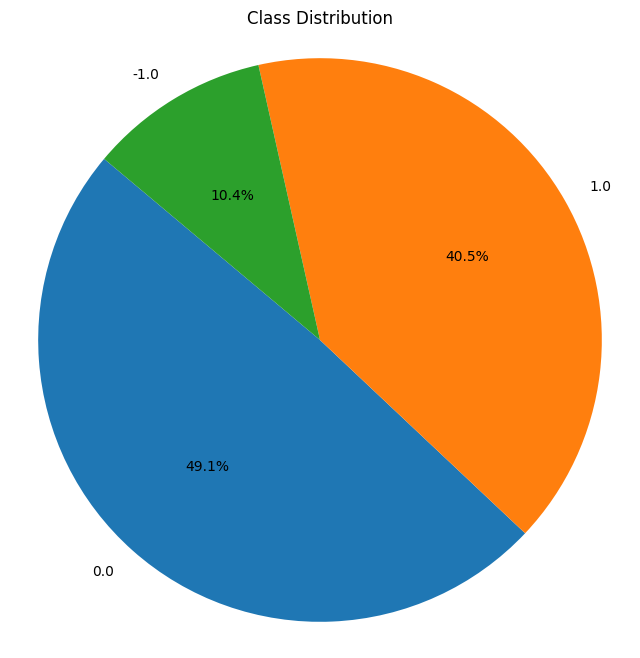

In [61]:
#plotting the labels distribution
class_counts = train['label'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Class Distribution')
plt.show()

There are higher number of netrual tweet reponses on Covid Vaccines.

### Data Splitting for modelling
Using traintest split we are going to split the train to train set where the model can learn and evaluation set where we can compute the metric scores

In [13]:
# Split the train data => {train, eval}
train_set, eval = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

In [14]:
#preview of train set
train_set.head(5)

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickey's Measles has gone international <url>,0.0,1.000000
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.000000
795,EI10PS46,<user> your ignorance on vaccines isn't just ...,1.0,0.666667
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.000000
3431,NBBY86FX,In other news I've gone up like 1000 mmr,0.0,1.000000


In [15]:
#preview of eval set
eval.head(5)

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.000000
1754,2DD250VN,<user> no. I was properly immunized prior to t...,1.0,1.000000
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.000000
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.666667
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.000000


In [16]:
#checking shapes of the splitted sets
train_set.shape, eval.shape

((7999, 4), (2000, 4))

In [17]:
# Save splitted subsets
#train.to_csv("/content/drive/My Drive/Azubi-Africa--P5-Natural-Language-Processing-Project-Sentiment-Analysis/data/train_subset.csv", index=False)
#eval.to_csv("/content/drive/My Drive/Azubi-Africa--P5-Natural-Language-Processing-Project-Sentiment-Analysis/data/eval_subset.csv", index=False)

In [18]:
dataset = load_dataset('csv',
                        data_files={'train_set': '/content/drive/My Drive/Azubi-Africa--P5-Natural-Language-Processing-Project-Sentiment-Analysis/data/train_subset.csv',
                        'eval': '/content/drive/My Drive/Azubi-Africa--P5-Natural-Language-Processing-Project-Sentiment-Analysis/data/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train_set split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

## IV. Modelling - Data Preposessing, Model training and evaluation

In [19]:
#transforming the datasets
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [20]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/9999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
#previewing the dataset
dataset

DatasetDict({
    train_set: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

## Model Training

In [24]:
#Instantiate the training and validation stets with random state of 12
train_set = dataset['train_set'].shuffle(seed = 12)
eval_set = dataset['eval'].shuffle(seed = 12)

In [27]:
#convert train date to pytorch tensore to speed up training and add padding
#data_collator_with_padding = DataCollatorWithPadding(
    #tokenizer=tokenizer,  # Your instantiated tokenizer
    #padding=True,  # Padding enabled
    #max_length=256,  # Maximum sequence length
    #return_tensors='pt'  # Return PyTorch tensors)

In [68]:
# Define your custom loss function
#def custom_loss(predictions, labels, computed_weights):
    # Compute the loss using the provided weights
    #loss = torch.nn.functional.cross_entropy(predictions, labels, weight=computed_weights)
    #return loss

In [73]:
batch_size = 16
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("roberta_trainer", num_train_epochs=3, load_best_model_at_end=True,push_to_hub=True,
                                  evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_steps = batch_size,
    save_steps= batch_size,
    save_strategy="steps",
    learning_rate=2e-5,
    weight_decay = 0.01
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [30]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
#moving training set and eval set to GPU
#train_set_gpu = []
#for example in train_set:
    #example_gpu = {}
    #for key, tensor in example.items():
        #if isinstance(tensor, torch.Tensor):  # Check if the element is a tensor
         #   example_gpu[key] = tensor.to('cuda:0')  # Move the tensor to the GPU
        #else:
           # example_gpu[key] = tensor  # Keep non-tensor data unchanged
    #train_set_gpu.append(example_gpu)

#eval_set_gpu = []
#for example in eval_set:
    #example_gpu = {}
   # for key, tensor in example.items():
    #    if isinstance(tensor, torch.Tensor):
       #     example_gpu[key] = tensor.to('cuda:0')
     #   else:
   #         example_gpu[key] = tensor
   # eval_set_gpu.append(example_gpu)

#instantiate trainer
roberta_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set, eval_dataset=eval_set)
    #data_collator=data_collator_with_padding,  # The data collator you defined earlier
    #tokenizer=tokenizer)

# Compute weights for your loss function
#computed_weights = torch.tensor([1., 0., -1.], device='cuda:0')  # Ensure the weights are on the same device

# Modify the trainer's loss function with the custom loss and computed weights
#roberta_trainer.compute_loss = lambda model, inputs, return_outputs=False: custom_loss(
 #   model(**inputs).logits, inputs["labels"], computed_weights)

In [ ]:
#model training
roberta_trainer.train()

Step,Training Loss,Validation Loss
16,0.000000,nan
32,0.000000,nan
48,0.000000,nan
64,0.000000,nan
80,0.000000,nan
96,0.000000,nan
112,0.000000,nan
128,0.000000,nan
144,0.000000,nan
160,0.000000,nan


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-78-0eb7d5474f72>", line 2, in <cell line: 2>
    roberta_trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1546, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1922, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2271, in _maybe_log_save_evaluate
    metrics = self.evaluate(ignore_keys=ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 3033, in evaluate
    self.log(output.metrics)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2645, in